<center><h1>Coursera IBM Capstone Project</h1></center>

<center><h1>The Battle of Neighborhoods - An Attempt to Cluster Berlin Neighborhoods by Their Living Standards</h1></center>

<h3>Abstract</h3>
This notebook contains thoughts and codes originated while exploring the location data of Berlin on the Foursquare API. The main effort was given to developing a primitive formula to calculate the so-called 'walkability' score. The KMeans clustering was used to inspect the original Foursquare data and to visualize the outcomes of different clustering inputs. As a final step, the neighborhood labels were grouped and summed by boroughs, the mean of the labels was taken as the borough label. The clusters were compared with the borough average rent price of 2017.

Duo to the primitiveness of the 'walkability' formula, the lack of details such as 'negative venues', the limit of 100 items per request, and more detailed GeoJson data for Berlin, the results were not satisfying. However, with more general data (besides the POIs), a better model to describe the neighborhoods' development could probably achieved even without user data.  

<h2>Introduction: Investing into Berlin's real estate market without being super rich?</h2>

Germany's capital Berlin has been known since some years for its gentrification problem. Real estate funds and managers have been most active in the popular areas like Prenzlauer Berg, Friedrichshain or Charlottenburg, where affordable living places became very rare.

It has become difficult not only for tenants, who cannot find appropriate housing near their work or their accustomed social environments, but also for regular house owners or investors with less resources to allocate their improvements/investments properly. The objects in the popular areas are now too expensive to be profitable, and the development of the poorer areas is difficult to anticipate. Another aspect of the gentrification is that the popular areas do not always expand (inelastic, for an interesting discussion see http://urbanspatialanalysis.com/riding-and-clustering-the-gentrification-wave/).

An example is the neighborhood Spandau Neustadt situated in the borough Spandau (up to 1920 a village of its own right). It is separated by a huge cross way with a roundabout from the comparably wealthy Spandau Altstadt. Although pertaining to the same locality Spandau, these two neighborhoods haven't been able to melt, until the gentrification of more central Berlin compelled the investors to explore Spandau Neustadt because it is actually very well situated (near train, bus, sbahn stations and directly at the river Havel). Yet the question of whether the installation of more luxurious apartments would eventually attract more wealthy residents still remains.

Figure 1 shows the housing situations in Spandau
<img src="RentPriceMapSpandau.JPG">
<center>Figure 1 Rent Situations in Spandau 2019, source: https://fbinter.stadt-berlin.de/fb/?loginkey=showMap&mapId=k_wohnlagenadr2019@senstadt</center>


By leveraging the Foursquare location data neighborhoods can be clustered by the types of venues. In a metropolitan area like Berlin, the density of common commerce is, however, not indicative for the area development. The existence of 'special' commodities has to be filtered out to qualify the specific neighborhoods. Using venue data, metrics for measuring the living standards such as 'walkability' or perception of safety (see e.g. https://arxiv.org/pdf/1808.02547.pdf)  could also be implemented in a crude way.

Besides the profitability of an object, the question of the middle to long term development of an area concerns middle class house owners and investors. Obviously, this cannot be answered without historical data. Nevertheless, to extract characteristic 'pictures' of economically successful districts can help to develop indicative factors that will aid one's decision making.

<h2>Data</h2>
I. Foursquare venues data. Originally repeated requests to accumulate data were planned. It was given up because each request returned approximately the same data. A request with a radius of 3000m returned around 7000 items. Many of them were duplicates and the distances over 500m didn't serve for the reflection on the 'walkability' score. Eventually a data set of 1790 items à radius 500m was applied.
Especially the categories of the venues were used to profile the neighborhoods. Special attention shall was payed to distinguishing commodities. The walkability of amenities was calculated between the points appointed by the neighborhood coordinates and the venues. The perception of security could have been deduced by the existence of gambling places or sex-related places; but Foursquare does not provide such data;

II. Coordinates of Berlin, and of all neighborhoods of Berlin City were requested through geopy.geocoders.Nominatim. Finally I decided to use Choropleth map because of the visibility of the boundaries. For this purpose, a GeoJson was found on GitHub: https://raw.githubusercontent.com/funkeinteraktiv/Berlin-Geodaten/master/berlin_bezirke.geojson;

III. A primitive list of the average rent price per boroughs of 2017. It was used as a control of the results of different clustering inputs. Why does one need to pay for this kind of data, by the way? https://de.statista.com/statistik/daten/studie/259905/umfrage/mietpreise-in-berlin-nach-bezirken/ 

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import re
import csv
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import numpy as np
import folium
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Scrape and request the neighborhoods' names and their coordinates
berlin_coordinates = pd.read_csv('berlin_coordinates.csv')
berlin_coordinates.head()

,borough,neighborhood,latitude,longitude
0,Tempelhof-Schöneberg,Schöneberg,52.482157,13.355190
1,Neukölln,Rudow,52.414680,13.498618
2,Neukölln,Gropiusstadt,52.424949,13.466183
3,Mitte,Mitte,52.517690,13.402376
4,Mitte,Moabit,52.530102,13.342542


In [3]:
# load the requested data from Foursquare
# two sets with 500m and 1000m radius
berlin_venues500 = pd.read_csv('berlin_venues500.csv')
#erlin_venues1000 = pd.read_csv('berlin_venues1000.csv')

In [4]:
# laod the venue category mapping
venues_map = pd.read_csv('venues_map.csv')

In [5]:
# merge dataframes
berlin_venues500 = pd.merge(berlin_venues500, venues_map, on='venue category', how='left')
berlin_venues500.head()

,neighborhood,neighborhood latitude,neighborhood longitude,venue id,venue,venue latitude,venue longitude,venue distance,venue category,venue map
0,Schöneberg,52.482157,13.35519,5019097de4b00b74aae82f54,Rüyam Gemüse Kebap,52.484807,13.353681,312,Doner Restaurant,regular food
1,Schöneberg,52.482157,13.35519,58addab2561ded1ef9db0bb1,Sahara Sudanesische Spezialitäten,52.479845,13.351810,344,African Restaurant,recreation/posh food
2,Schöneberg,52.482157,13.35519,4d5673a7611aa35d45204139,Gasometer,52.482659,13.359606,304,Event Space,recreation
3,Schöneberg,52.482157,13.35519,579b7d3b498ea8f02d59f2f3,Café de Enrico,52.481014,13.349788,387,Café,recreation/posh food
4,Schöneberg,52.482157,13.35519,565efdcb498e8a489cb29d35,Kleine Fabriek,52.481447,13.360373,360,Baby Store,recreation/posh shop


In [6]:
# count numbers of each venue map category
cat_count = venues_map.groupby('venue map').count()
cat_count

,venue category
venue map,
?,1
business,9
household supply,22
medicine supply,2
public welfare,4
recreation,59
recreation/art,20
recreation/posh food,110
recreation/posh shop,39


In [7]:
venues_count = berlin_venues500[['venue', 'venue map']].groupby('venue map').count()
venues_count

,venue
venue map,
?,1
business,12
household supply,99
medicine supply,158
recreation,74
recreation/art,48
recreation/posh food,463
recreation/posh shop,60
recreation/sports,54


## Calculate the 'Walkability' Score

In [8]:
# a function to calculate score
def getScore(df, neighborhood):
    neighborhoods = df[['neighborhood', 'venue', 'venue distance', 'venue category', 'venue map']].groupby(['neighborhood'])
    neighborhood_df = neighborhoods.get_group(neighborhood)
    

    regFood = neighborhood_df[neighborhood_df['venue map'] =='regular food'].groupby(['venue map'])['venue'].count()
    transport2 = neighborhood_df[(neighborhood_df['venue map'] == 'transportation2')].groupby(['venue map'])['venue'].count()
    hsupply = neighborhood_df[(neighborhood_df['venue map'] == 'household supply')].groupby(['venue map'])['venue'].count()
    msupply = neighborhood_df[(neighborhood_df['venue map'] == 'medicine supply')].groupby(['venue map'])['venue'].count()
    rec = neighborhood_df[neighborhood_df['venue map'].str.contains('recreation')]['venue'].count()
    
    try:
        food = regFood['regular food']
    except:
        food = 0
    try:
        transport = transport2['transportation2']
    except:
        transport = 0
    try:
        h = hsupply['household supply']
    except:
        h = 0
    try:
        m = msupply['medicine supply']
    except:
        m = 0
    try:
        rec = rec
    except:
        rec = 0
        
    score = round((food * 0.20 + transport * 0.30 + h * 0.05 + m * 0.10 + rec * 0.35) / (food + transport + h + m + rec), 2)
    
    return(score)    

In [9]:
spandauNeustadtScore = getScore(berlin_venues500, 'Spandau Neustadt')
spandauNeustadtScore

0.2

In [10]:
heiligenseeScore = getScore(berlin_venues500, 'Heiligensee')
heiligenseeScore

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


nan

In [11]:
def getAllScores(df):
    neighborhood_names = df['neighborhood'].unique()
    neighborhood_names = list(neighborhood_names)
    scoreList = []
    for name in neighborhood_names:
        score = getScore(df, name) 
        scoreList.append((name, score))
        
    scores = pd.DataFrame(scoreList, columns=['neighborhood', 'wscore'])    
    return(scores)  

In [12]:
scores = getAllScores(berlin_venues500)
scores.head

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


<bound method NDFrame.head of                  neighborhood  wscore
0                  Schöneberg    0.27
1                       Rudow    0.19
2                Gropiusstadt    0.24
3                       Mitte    0.33
4                      Moabit    0.25
5                Hansaviertel    0.29
6                  Tiergarten    0.31
7                     Wedding    0.19
8               Gesundbrunnen    0.23
9              Friedrichshain    0.29
10                  Kreuzberg    0.30
11            Prenzlauer Berg    0.28
12                  Weißensee    0.28
13                Blankenburg    0.23
14                Heinersdorf    0.26
15                      Karow    0.21
16                     Pankow    0.33
17               Blankenfelde    0.25
18                       Buch    0.19
19       Französisch Buchholz    0.22
20          Niederschönhausen    0.24
21                  Rosenthal    0.24
22                Wilhelmsruh    0.19
23             Charlottenburg    0.26
24                Wi

In [13]:
# clean the score dataframe
scores['wscore'] = scores['wscore'] * 100
scores['wscore'].fillna(0, inplace=True)
scores['wscore'] = scores['wscore'].astype(int)

## Cluster and compare

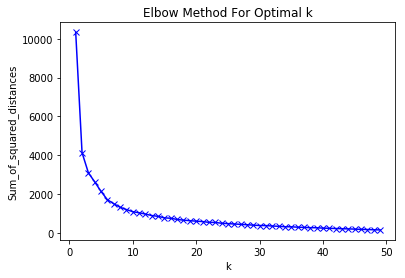

In [16]:
# find the k for clustering
#test_onehot = pd.get_dummies(berlin_venues500[['venue map']], prefix='', prefix_sep='')
#test_onehot['neighborhood'] = berlin_venues500['neighborhood']
#fixed_columns = [test_onehot.columns[-1]] + list(test_onehot.columns[:-1])
#test_onehot = test_onehot[fixed_columns]
#test_grouped = test_onehot.groupby('neighborhood').sum().reset_index()
#test_cluster = test_grouped.drop(['neighborhood'], 1)

#t_onehot = pd.concat([berlin_venues500, pd.get_dummies(berlin_venues500['venue map'])], axis=1)
#column_list = [i for i in berlin_venues500['venue map'].unique()]
#column_list = [e for e in column_list if e not in ('regular food', 'transportation2', 'household supply', 'medicine supply')]
#column_list.append('wscore')
#t_onehot_grouped = t_onehot.groupby('neighborhood').sum().reset_index()
#t_onehot_grouped = pd.merge(t_onehot_grouped, scores, on='neighborhood', how='left')
#kmeans = KMeans(n_clusters=10, random_state=0).fit(onehot_grouped[column_list])


#distance=[]

kclusters= range(1,50)
for k in kclusters:
# run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(test_cluster)
    distance.append(kmeans.inertia_)

# Checking the elbow to find th emost desirable K-value

plt.plot(kclusters,distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()    

In [17]:
# a function to cluster
# df = dataFrame, df1 = selected from df

def getCluster(df, df1, k):
    onehot = pd.concat([df, pd.get_dummies(df1)], axis=1)
    column_list = [i for i in df1.unique()]
    onehot_grouped = onehot.groupby('neighborhood').sum().reset_index()
    kmeans = KMeans(n_clusters=k, random_state=0).fit(onehot_grouped[column_list])
    onehot_grouped.insert(0, 'cluster labels', kmeans.labels_)
    return(onehot_grouped)    

In [18]:
# try berlin_venues500[['venue category']]
venueCategory_cluster = getCluster(berlin_venues500, berlin_venues500['venue category'], 15)
venueCategory_cluster_m = pd.merge(venueCategory_cluster, berlin_coordinates[['neighborhood', 'borough']], on= 'neighborhood', how='left')
test1 = venueCategory_cluster_m[['cluster labels', 'neighborhood', 'borough']].groupby('borough')['cluster labels'].mean()
test1.head()


borough
Charlottenburg-Wilmersdorf    5.857143
Friedrichshain-Kreuzberg      8.000000
Lichtenberg                   3.454545
Marzahn-Hellersdorf           6.600000
Mitte                         5.666667
Name: cluster labels, dtype: float64

In [19]:
berlin_geo = r'berlin.geojson'

In [20]:
berlin_map = folium.Map(location=[52.5243700, 13.4105300], zoom_start=11)

berlin_map.choropleth(
    geo_data=berlin_geo,
    data=test1,
    columns=['borough', 'cluster labels_y'],
    key_on='feature.properties.name',
    fill_color='BuPu', 
    fill_opacity=0.50, 
    line_opacity=0.2,
    legend_name='Neighborhoods According to Trendy Places'
)

berlin_map.save('cluster1.html')
# display map
berlin_map

In [21]:
# check the distribution of the boroughs respective to their cluster labels
test1_binned = pd.cut(test1, bins=3).sort_values(ascending=False)
test1_binned

borough
Marzahn-Hellersdorf             (5.846, 8.0]
Friedrichshain-Kreuzberg        (5.846, 8.0]
Charlottenburg-Wilmersdorf      (5.846, 8.0]
Tempelhof-Schöneberg          (3.692, 5.846]
Steglitz-Zehlendorf           (3.692, 5.846]
Spandau                       (3.692, 5.846]
Neukölln                      (3.692, 5.846]
Mitte                         (3.692, 5.846]
Treptow-Köpenick              (1.532, 3.692]
Reinickendorf                 (1.532, 3.692]
Pankow                        (1.532, 3.692]
Lichtenberg                   (1.532, 3.692]
Name: cluster labels, dtype: category
Categories (3, interval[float64]): [(1.532, 3.692] < (3.692, 5.846] < (5.846, 8.0]]

In [22]:
rentPrice2017 = pd.read_csv('rentPrice2017.csv')

rentPrice2017['binned'] = pd.cut(rentPrice2017['mean rent price 2017'], bins= 3).sort_values(ascending=False)
rentPrice2017

,borough,mean rent price 2017,binned
0,Friedrichshain-Kreuzberg,11.91,"(10.387, 11.91]"
1,Mitte,11.83,"(10.387, 11.91]"
2,Charlottenburg-Wilmersdorf,11.23,"(10.387, 11.91]"
3,Pankow,10.06,"(8.863, 10.387]"
4,Neukölln,9.83,"(8.863, 10.387]"
5,Steglitz-Zehlendorf,9.80,"(8.863, 10.387]"
6,Tempelhof-Schöneberg,9.70,"(8.863, 10.387]"
7,Lichtenberg,9.10,"(8.863, 10.387]"
8,Treptow-Köpenick,8.98,"(8.863, 10.387]"
9,Reinickendorf,8.62,"(7.335, 8.863]"


Try the mapped categories:

In [23]:
# bin the results and compare to the mietpreis
venueMap_cluster = getCluster(berlin_venues500, berlin_venues500['venue map'], 10)
venueMap_cluster_m = pd.merge(venueMap_cluster, berlin_coordinates[['neighborhood', 'borough']], on= 'neighborhood', how='left')
test2 = venueMap_cluster_m[['cluster labels', 'neighborhood', 'borough']].groupby('borough')['cluster labels'].mean()
test2.head()

borough
Charlottenburg-Wilmersdorf    2.857143
Friedrichshain-Kreuzberg      1.000000
Lichtenberg                   6.545455
Marzahn-Hellersdorf           1.200000
Mitte                         4.666667
Name: cluster labels, dtype: float64

In [24]:
berlin_map2 = folium.Map(location=[52.5243700, 13.4105300], zoom_start=11)

berlin_map2.choropleth(
    geo_data=berlin_geo,
    data=test2,
    columns=['borough', 'cluster labels_y'],
    key_on='feature.properties.name',
    fill_color='BuPu', 
    fill_opacity=0.50, 
    line_opacity=0.2,
    legend_name='Neighborhoods According to Generalized Categories'
)

berlin_map2.save('cluster2.html')
# display map
berlin_map2

In [25]:
# check the distribution of the boroughs respective to their cluster labels
test2_binned = pd.cut(test2, bins=3).sort_values(ascending=False)
test2_binned

borough
Steglitz-Zehlendorf           (4.758, 6.636]
Reinickendorf                 (4.758, 6.636]
Lichtenberg                   (4.758, 6.636]
Treptow-Köpenick              (2.879, 4.758]
Spandau                       (2.879, 4.758]
Pankow                        (2.879, 4.758]
Neukölln                      (2.879, 4.758]
Mitte                         (2.879, 4.758]
Tempelhof-Schöneberg          (0.994, 2.879]
Marzahn-Hellersdorf           (0.994, 2.879]
Friedrichshain-Kreuzberg      (0.994, 2.879]
Charlottenburg-Wilmersdorf    (0.994, 2.879]
Name: cluster labels, dtype: category
Categories (3, interval[float64]): [(0.994, 2.879] < (2.879, 4.758] < (4.758, 6.636]]

## Try clustering with the WScore

In [26]:
# merge dataframes
onehot = pd.concat([berlin_venues500, pd.get_dummies(berlin_venues500['venue map'])], axis=1)
column_list = [i for i in berlin_venues500['venue map'].unique()]
column_list = [e for e in column_list if e not in ('regular food', 'transportation2', 'household supply', 'medicine supply')]
column_list.append('wscore')
onehot_grouped = onehot.groupby('neighborhood').sum().reset_index()
onehot_grouped = pd.merge(onehot_grouped, scores, on='neighborhood', how='left')
kmeans = KMeans(n_clusters=10, random_state=0).fit(onehot_grouped[column_list])
onehot_grouped.insert(0, 'cluster labels', kmeans.labels_)
onehot_grouped.head()

,cluster labels,neighborhood,neighborhood latitude,neighborhood longitude,venue latitude,venue longitude,venue distance,?,business,household supply,medicine supply,recreation,recreation/art,recreation/posh food,recreation/posh shop,recreation/sports,regular food,tourism,traffic,transportation1,transportation2,view,wscore
0,1,Adlershof,891.444184,230.308343,891.437352,230.314220,3906,0,0,0,4,0,0,4,1,1,6,0,0,0,1,0,24
1,3,Alt-Hohenschönhausen,788.256137,202.538237,788.241813,202.529760,5032,0,0,3,2,0,0,2,0,0,6,0,0,0,2,0,19
2,7,Alt-Treptow,1469.791775,376.876480,1469.786026,376.869555,7185,0,0,3,2,1,1,7,3,1,5,0,1,2,0,2,26
3,3,Baumschulenweg,314.770163,80.889287,314.782986,80.909871,1998,0,0,1,1,0,0,1,0,0,3,0,0,0,0,0,18
4,1,Biesdorf,630.131906,162.660157,630.133231,162.678506,3730,0,0,0,1,1,0,1,0,0,5,0,0,0,1,3,23


In [27]:
wScore_cluster_m = pd.merge(onehot_grouped, berlin_coordinates[['neighborhood', 'borough']], on= 'neighborhood', how='left')
test3 = wScore_cluster_m[['cluster labels', 'neighborhood', 'borough']].groupby('borough')['cluster labels'].mean()
test3.head()

borough
Charlottenburg-Wilmersdorf    3.142857
Friedrichshain-Kreuzberg      4.500000
Lichtenberg                   4.090909
Marzahn-Hellersdorf           3.400000
Mitte                         4.000000
Name: cluster labels, dtype: float64

In [28]:
berlin_map3 = folium.Map(location=[52.5243700, 13.4105300], zoom_start=11)

berlin_map3.choropleth(
    geo_data=berlin_geo,
    data=test3,
    columns=['borough', 'cluster labels_y'],
    key_on='feature.properties.name',
    fill_color='BuPu', 
    fill_opacity=0.50, 
    line_opacity=0.2,
    legend_name='Neighborhoods According to WScore & Generalized Categories'
)

berlin_map3.save('cluster3.html')
# display map
berlin_map3

In [29]:
test3_binned = pd.cut(test3, bins=3).sort_values(ascending=False)
test3_binned

borough
Steglitz-Zehlendorf             (3.867, 4.8]
Spandau                         (3.867, 4.8]
Neukölln                        (3.867, 4.8]
Mitte                           (3.867, 4.8]
Lichtenberg                     (3.867, 4.8]
Friedrichshain-Kreuzberg        (3.867, 4.8]
Treptow-Köpenick              (2.933, 3.867]
Reinickendorf                 (2.933, 3.867]
Marzahn-Hellersdorf           (2.933, 3.867]
Charlottenburg-Wilmersdorf    (2.933, 3.867]
Tempelhof-Schöneberg          (1.997, 2.933]
Pankow                        (1.997, 2.933]
Name: cluster labels, dtype: category
Categories (3, interval[float64]): [(1.997, 2.933] < (2.933, 3.867] < (3.867, 4.8]]